In [25]:
import pandas as pd
import numpy as np
import os
from os import path
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import re
import traceback
%matplotlib inline

In [2]:
# focus on three regions now
regions = [
    "Burgenland",
    "Kärnten",
    "Niederösterreich",
    "Oberösterreich",
    "Salzburg",
    "Steiermark",
    "Tirol",
    "Vorarlberg",
    "Wien"
]
region_dirs = ["/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_{}_gw_{}".format(num, regions[idx]) for idx, num in enumerate(range(1, len(regions)+1))]
region_dirs

['/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_1_gw_Burgenland',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_2_gw_Kärnten',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_3_gw_Niederösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_4_gw_Oberösterreich',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_6_gw_Steiermark',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_7_gw_Tirol',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_8_gw_Vorarlberg',
 '/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/ehyd_messstellen_9_gw_Wien']

## Measuring point data with regions

In [3]:
def get_num_from_str(string):
    matches = re.findall(r"\d+\.\d+", string)
    if len(matches):
        return matches[0]
    else:
        return np.nan

def get_mp_attrs(region, region_dir, mp_num):

    mp_base_data_path = path.join(region_dir, "Stammdaten", "Stammdaten-{0}.txt".format(mp_num))
    
    land_height = np.nan
    mp_height = np.nan
    bottom_line = np.nan
    t_measuring_depth = np.nan
    
    with open(mp_base_data_path, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if "Geländehöhe" in line:
                land_height = get_num_from_str(line)
                
            elif "Messpunkthöhe" in line:
                mp_height = get_num_from_str(line)
                
            elif "Sohllage" in line:
                bottom_line = get_num_from_str(line)
                
            elif "T-Messtiefe u.GOK" in line:
                t_measuring_depth = get_num_from_str(line)
                
                break # since it's always listed latest in the file
    
    mp = {
        "land_height": land_height,
        "mp_height": mp_height,
        "bottom_line": bottom_line,
        "t_measuring_depth": t_measuring_depth
    }
    
    return mp


# test
region_idx = 0

# try mp with full attr
mp_num = 305540
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

# try mp with missing attr -> np.nan in missed value
mp_num = 300137
mp_attrs = get_mp_attrs(regions[region_idx], region_dirs[region_idx], mp_num = mp_num)
print("mp {0} attrs:".format(mp_num), mp_attrs)

mp 305540 attrs: {'land_height': '120.68', 'mp_height': '120.88', 'bottom_line': '114.98', 't_measuring_depth': '5.60'}
mp 300137 attrs: {'land_height': '154.76', 'mp_height': '154.76', 'bottom_line': '151.36', 't_measuring_depth': nan}


In [4]:
values = []

for i in range(len(regions)):
    region = regions[i]
    region_dir = region_dirs[i]
    # mps: measurment points 
    df_mps_path = path.join(region_dir, "messstellen_alle.csv")
    df_mps = pd.read_csv(df_mps_path, sep=";")
    # filter to typ == 'gw' then del typ col
    df_mps = df_mps.query("typ=='gw'")
    del df_mps["typ"]
    
    df_mps["region"] = region
    
    # for every mp in the region get attributes
    # create attrs cols and init with np.nan
    mp_attrs = ["land_height", "mp_height", "bottom_line", "t_measuring_depth"]
    for mp_attr in mp_attrs:
        df_mps[mp_attr] = np.nan
    
    # fill with values when available
    for index, row in df_mps.iterrows():
        mp_num = row["hzbnr01"]
        mp_attr_vals = get_mp_attrs(region, region_dir, mp_num = mp_num)
        for mp_attr in mp_attrs:
            df_mps.at[index, mp_attr] = float(mp_attr_vals[mp_attr])
    
    values.extend(df_mps.values.tolist())

colnames = ["x", "y", "dbmsnr", "hzbnr01", "region"] + mp_attrs
df_mps_all = pd.DataFrame(values, columns = colnames)
df_mps_all["x"] = df_mps_all["x"].str.replace(",", ".").astype(float)
df_mps_all["y"] = df_mps_all["y"].str.replace(",", ".").astype(float)

df_mps_all

,x,y,dbmsnr,hzbnr01,region,land_height,mp_height,bottom_line,t_measuring_depth
0,679020.30,448967.00,1002266,335588,Burgenland,125.76,126.66,108.29,NaN
1,643311.78,398158.79,1002285,335810,Burgenland,235.69,236.59,225.74,10.00
2,616039.28,341145.21,1002422,345876,Burgenland,234.06,234.86,228.06,NaN
3,615420.17,341879.22,1002237,335299,Burgenland,238.18,238.28,233.38,NaN
4,665124.60,430698.99,1002327,345256,Burgenland,116.99,117.54,114.65,NaN
...,...,...,...,...,...,...,...,...,...
3786,631609.35,485861.88,9002133,319749,Wien,157.12,157.07,142.07,NaN
3787,622685.15,480101.35,9002268,350074,Wien,187.09,187.94,175.89,NaN
3788,633723.06,481067.86,9002260,350116,Wien,160.93,161.93,150.93,NaN
3789,633459.50,482115.68,9002231,341438,Wien,154.76,155.71,145.15,6.05


In [5]:
sub_path = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/processed/gw_test_empty.csv"
submission_df = pd.read_csv(sub_path)
test_ids = submission_df.columns[1:]

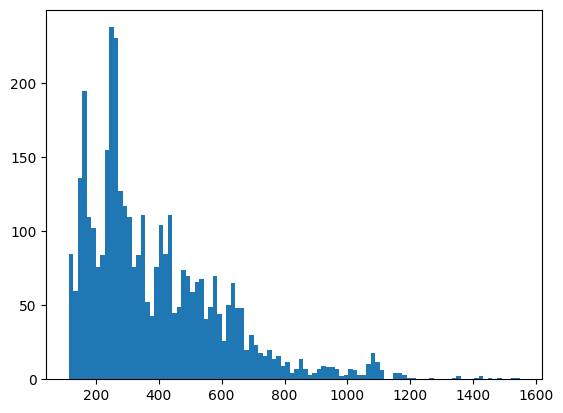

In [6]:
plt.hist(df_mps_all["land_height"], bins=100);

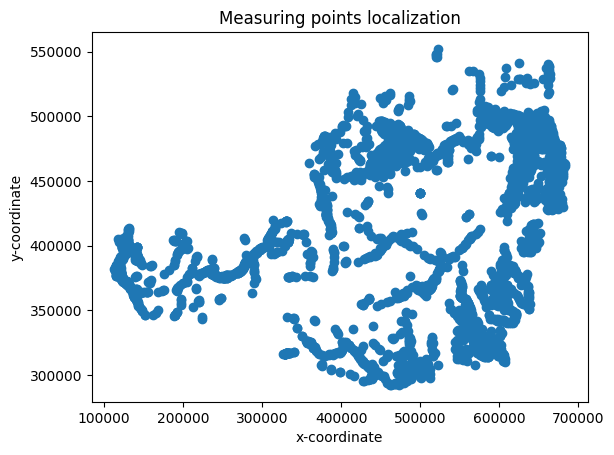

In [7]:
plt.scatter(df_mps_all["x"], df_mps_all["y"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.title("Measuring points localization")
plt.show()

## Process region directory data

In [36]:
# know how many rows to skip in pd.read_csv
def csv_find_skiprows(filepath, lookup):
    skiprows = 0
    # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
    with open(filepath, encoding='unicode_escape') as f:
        for num, line in enumerate(f, 1):
            if lookup in line:
                skiprows = num
                # print("skiprows:", skiprows)
                break
                
    return skiprows

def process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=False):

    index = region_dir.find("/raw/")
    
    outward_dir = region_dir[:index + len('/raw/')]
    
    folder_dir = path.join(region_dir, folder_name)
    
    print("> Processing {} - {}..".format(region, folder_name))
    
    # clean previous processing output
    output_dir = path.join(folder_dir, "processed_data")

    outward_dir = path.join(outward_dir, "processed_data")
    
    if not path.exists(outward_dir): 
        os.mkdir(outward_dir)
        
    try:
        shutil.rmtree(output_dir)
    except:
        pass
    os.mkdir(output_dir)
    
    filenames = os.listdir(folder_dir)
    for filename in filenames:

        mp_num = filename.split(".")[0].split("-")[-1]

        if mp_num not in test_ids:
            continue
        
        filepath = path.join(folder_dir, filename)
        
        # process only files (don't iterate over output dir)
        if not path.isfile(filepath):
            continue
        
        # first know how many rows to skip in pd.read_csv. TO do this will open the file and look for "Werte:"
        lookup = "Werte:"
        skiprows = csv_find_skiprows(filepath, lookup)
        
        # load and process .csv file
     
        df = pd.read_csv(filepath, sep=" ;", header=None, skiprows=skiprows,
                               encoding='unicode_escape')
        

        # manipulate data splitting values into more possible regressors (e.g. date -> day, month, year)
        df.columns = ["date", val_col_name, "empty"]
        del df["empty"] 
        
        df["date"] = pd.to_datetime(df["date"].str.strip(), format='%d.%m.%Y %H:%M:%S')
        df.set_index("date", inplace=True)
        datetime_seq = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

       
        #if len(df) != len(datetime_seq):
        df2 = pd.DataFrame(datetime_seq, columns=["date"])
        
        # Use boolean indexing to assign values
        for date in datetime_seq:
            if date in df.index:
                value =  df.loc[date, val_col_name]
                df2.loc[df2['date'] == date, val_col_name] = float(value.replace(",",".")) if "Lücke" not in value else value
            else:
                df2.loc[df2['date'] == date, val_col_name] = np.nan
    
        # Use regex to handle variations of "Lücke"
        regex_pattern = r'\bLücke\b' 
    
        # Replace variations of "Lücke" with NaN
        df2[val_col_name] = df2[val_col_name].astype(str).replace(regex_pattern, np.nan, regex=True)
    
        # Convert to float and handle NaN interpolation
        df2[val_col_name] = pd.to_numeric(df2[val_col_name], errors='coerce')
        df2[val_col_name] = df2[val_col_name].interpolate(method="linear")
        df2[val_col_name] = df2[val_col_name].round(2)
        
        # remove the last year 2022-01-01 on the date column
        last_date = df2['date'].max()
        if '2022-01-01' in str(last_date):
            df2 = df2.iloc[:-1]
        df = df2

        # # add more time series for test data
        last_date = df["date"].max()
        new_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=26, freq='MS')

        # Create a DataFrame with the new dates
        new_data = pd.DataFrame({"date": new_dates})
        df = pd.concat([df, new_data], ignore_index=True)

        

        # add calender features
        df["month"] = df["date"].dt.month
        df["year"] = df["date"].dt.year
        df["quarter"] = df["date"].dt.quarter

        # add season features
        df["season"] = df["date"].dt.month.apply(get_season)
        df["weather"] = df["date"].dt.month.apply(get_weather)
        df["season"] = df["season"].astype("category")
        df["weather"] = df["weather"].astype("category")
        
        # cyclic calender and seasonal features
        month_cyclic = cyclical_encoded(df["month"], cycle_length=24)
        quarter_cyclic = cyclical_encoded(df["quarter"], cycle_length=4)

        # merge the df to the cyclic the features
        df_exogenous_features = pd.concat([df,month_cyclic, quarter_cyclic], axis=1)

        # add intereaction between exogenous varibles
        transformer_poly = PolynomialFeatures(
        degree           = 2,
        interaction_only = True,
        include_bias     = False
        ).set_output(transform="pandas")
    
        # pick columns for exgennous varibles for intereactions
        copy_df = df_exogenous_features.copy()
        copy_df.drop(["season","weather","date",val_col_name], axis=1, inplace=True)
        poly_cols = copy_df.columns.tolist()
    
        poly_features = transformer_poly.fit_transform(df_exogenous_features[poly_cols].dropna())
        poly_features = poly_features.drop(columns=poly_cols)
        poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
        poly_features.columns = poly_features.columns.str.replace(" ", "_")
        df_exogenous_features = pd.concat([df_exogenous_features, poly_features], axis=1)
        df_exogenous_features.set_index("date", inplace=True)
        #df_exogenous_features[val_col_name] = df_exogenous_features[val_col_name].astype(str)
        
        
        #convert the ground water the level tot float
        # df_exogenous_features[val_col_name] = df_exogenous_features.apply(
        #     lambda row: float(row[val_col_name].split(" ;")[0].replace(",", "."))
        #     , axis=1
        # )
        # save processed data to file
        out_filename = "processed_{}".format(filename)
        file_path = path.join(output_dir, out_filename)
        df_exogenous_features.to_csv(file_path)
        del df
        
        # Copy the file to outward_dir
        new_filename = out_filename.replace("processed_Grundwasserstand-Monatsmittel", region)
        new_filepath = os.path.join(outward_dir, new_filename)
        shutil.copy(file_path, new_filepath)
        
        # if debugging, process only one file from each sub dir 
        if debugging:
            break
        
    print("\t- Done!")

    return None

In [37]:
# Define a function to map month to season for exogenous varibles
def get_season(month):
    if month in [3.0, 4.0, 5.0]:
        return 'spring'
    elif month in [6.0, 7.0, 8.0]:
        return 'summer'
    elif month in [9.0, 10.0, 11.0]:
        return 'Fall'
    else:  # months 12.0, 1.0, 2.0
        return 'winter'

def get_weather(month):
    if month in [12, 1, 2]:
        return "cold"
    elif month in [6, 7, 8]:
        return "warm"
    else: # months 3, 4, 5, 9, 10, 11
        return "normal"

def cyclical_encoded(data, cycle_length):
    """ function to capture pattern on calender features """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result

def process_region_files(region, region_dir, test_ids):
    
    # process and manipulate region files into clean .csv files
    FILE_PROCESSING_DEBUGGING = False # False => process  all files     
    folder_name = "Grundwasserstand-Monatsmittel"
    val_col_name = "gw-level"
    
    process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=FILE_PROCESSING_DEBUGGING)

In [38]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for i in range(9):
        region_idx = i
        region = regions[region_idx]
        region_dir = region_dirs[region_idx]
        process_region_files(region, region_dir, test_ids)

> Processing Burgenland - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Kärnten - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Niederösterreich - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Oberösterreich - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Salzburg - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Steiermark - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Tirol - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Vorarlberg - Grundwasserstand-Monatsmittel..
	- Done!
> Processing Wien - Grundwasserstand-Monatsmittel..
	- Done!


In [39]:
# check if the data is 487 in total as given on the deliverables
processed_data_dir = "/users/azeez/water_prediction/ai4ls_2_water_prediction/data/raw/processed_data/"
files = os.listdir(processed_data_dir)
print(f" Number of processed data : {len(files)}")

 Number of processed data : 487


In [40]:
# check irregularity in the datetime rangeindex
counter = 0
filenames_with_fault = []
for filename in files:
    path = os.path.join(processed_data_dir, filename)
    df = pd.read_csv(path)
    df.set_index("date", inplace=True)
    df_total = len(df.index)
    time_range = len(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))
    if df_total != time_range:
        counter += 1
        filenames_with_fault.append(filename)

print(counter)
filenames_with_fault

0


[]

In [ ]:
for filepath in filepaths:
    df = pd.read_csv(filepath, sep=" ;", header=None, skiprows=skiprows,
                               encoding='unicode_escape')
        

    # manipulate data splitting values into more possible regressors (e.g. date -> day, month, year)
    df.columns = ["date", val_col_name, "empty"]
    del df["empty"] 
    
    df["date"] = pd.to_datetime(df["date"].str.strip(), format='%d.%m.%Y %H:%M:%S')
    df.set_index("date", inplace=True)
    datetime_seq = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')

   
    #if len(df) != len(datetime_seq):
    df2 = pd.DataFrame(datetime_seq, columns=["date"])
    df2[val_col_name] = df2.apply(
        lambda row: df.loc[row["date"]][val_col_name] if row["date"] in df.index else np.nan, axis=1
    )
    # replace lucke with NAN and fill the nan with previous value
    df2[val_col_name] = df2[val_col_name].fillna(method="ffill")
    df2 = df2[df2[val_col_name].str.contains("Lücke")]
    lucke_idx = df2.index.tolist()
    df2.loc[lucke_idx, val_col_name] = np.nan
    df2[val_col_name] = df2[val_col_name].fillna(method="ffill").astype(str)
    print(df2.tail(20))
    df = df2

#### These filenames need to addressed to make sure the range index of the datetime are consistent on monthly frequency

## This is where I stopped for data preprocessing, you can check the other notebook for model training

In [39]:
def create_region_mps_summary(region, region_dir, df_mps, test_ids, debugging):
    
    summary_dir  = path.join(region_dir, "Summary")
    test_dir = path.join(region_dir, "test-data")
    
    print("> Creating {0} Summary..".format(region))
    
    # clean previous processing output   
    try:
        shutil.rmtree(summary_dir)
        shutil.rmtreea(test_dir)
    except:
        pass
    os.mkdir(summary_dir)
    os.mkdir(test_dir)
    
    try:
        # get processed monthly water level files as starting point
        prc_mnth_lvls_dir = path.join(region_dir, "Grundwasserstand-Monatsmittel", "processed_data")
        mnth_lvls_filenames = os.listdir(prc_mnth_lvls_dir)
        mp_num_dict = df_mps["hzbnr01"].to_dict()
        reverse_dict = {v: k for k, v in mp_num_dict.items()}
        
        
        for mnth_lvls_filename in mnth_lvls_filenames:
            
            mp_num = mnth_lvls_filename.split(".")[0].split("-")[-1]
            
            if debugging:
                mp_num = 305540 # override mp_num value to choose a mp that we have temperature data for
                print("mp_num:", mp_num)
                
            df = pd.read_csv(path.join(prc_mnth_lvls_dir, mnth_lvls_filename), sep=",")

            # add few features from measuring point dataframe: x & y coordinates and land height
            num = int(mp_num)
            df["x"] = df_mps.loc[reverse_dict[num]]["x"] if num in reverse_dict else np.nan
            df["y"] = df_mps.loc[reverse_dict[num]]["y"] if num in reverse_dict else np.nan
            df["land_height"] = df_mps.loc[reverse_dict[num]]["land_height"] if num in reverse_dict else np.nan
            
            # add extra fields, init them as NaN, then try to fill them with values
            # add fields: yr_max, yr_max_dist, yr_max_abs(dist)
            df["yr_max"] = np.nan
            df["yr_max_dist"] = np.nan
            df["yr_max_abs(dist)"] = np.nan
            
            yr_max_fpath = path.join(region_dir, "Grundwasserstand-Jahresmaxima", "processed_data", "processed_Grundwasserstand-Jahresmaxima-{0}.csv".format(mp_num))
            
            if path.exists(yr_max_fpath):
                
                df_yr_max = pd.read_csv(yr_max_fpath, sep=",")[["year", "gw-level"]]
                df_yr_max.drop_duplicates(subset=["year"], keep='first', inplace=True)
                
                # set yr as index and create dict for O(1) search
                df_yr_max.set_index("year", inplace=True)
                dct_yr_max = df_yr_max.to_dict("index")
                
                df["yr_max"] = df.apply(
                    lambda row: dct_yr_max[row["year"]]["gw-level"] if row["year"] in dct_yr_max else np.nan, axis=1)
                yr_max_mean = df["yr_max"].mean()
                df["yr_max"].fillna(round(yr_max_mean, 2), inplace=True)
                df["yr_max_dist"] = df.apply(lambda row: round(row["gw-level"] - row["yr_max"], 2), axis=1)
                # df["yr_max_dist"] = df.apply(
                #     lambda row: round(row["gw-level"] - row["yr_max"], 2) if not row["yr_max"] == np.nan else np.nan
                #     , axis=1)
                df["yr_max_abs(dist)"] = df["yr_max_dist"].abs().round(2)
            
                
                # free resources
                del df_yr_max
                del dct_yr_max
                
            # add fields: yr_min, yr_min_dist, yr_min_abs(dist)
            df["yr_min"] = np.nan
            df["yr_min_dist"] = np.nan
            df["yr_min_abs(dist)"] = np.nan
            
            yr_min_fpath = path.join(region_dir, "Grundwasserstand-Jahresminima", "processed_data", "processed_Grundwasserstand-Jahresminima-{0}.csv".format(mp_num))
            
            if path.exists(yr_min_fpath):
                
                df_yr_min = pd.read_csv(yr_min_fpath, sep=",")[["year", "gw-level"]]
                df_yr_min.drop_duplicates(subset=["year"], keep='first', inplace=True)
                
                # set yr as index and create dict for O(1) search
                df_yr_min.set_index("year", inplace=True)
                dct_yr_min = df_yr_min.to_dict("index")
                
                df["yr_min"] = df.apply(
                    lambda row: dct_yr_min[row["year"]]["gw-level"] if row["year"] in dct_yr_min else np.nan
                    , axis=1)
                yr_min_mean = df["yr_min"].mean()
                df["yr_min"].fillna(round(yr_min_mean, 2), inplace=True)
                df["yr_min_dist"] = df.apply(lambda row: round(row["gw-level"] - row["yr_min"], 2), axis=1)
                # df["yr_min_dist"] = df.apply(
                #     lambda row: round(row["gw-level"] - row["yr_min"], 2) if not row["yr_min"] == np.nan else np.nan
                #     , axis=1)
                df["yr_min_abs(dist)"] = df["yr_min_dist"].abs().round(2)
                
                # free resources
                del df_yr_min
                del dct_yr_min
                
            # add field: temp to add temperature (Celcius) to every monthly measurement if available   
            df["temp"] = np.nan
            
            mnth_temp_fpath = path.join(region_dir, "Grundwassertemperatur-Monatsmittel", "processed_data", "processed_Grundwassertemperatur-Monatsmittel-{0}.csv".format(mp_num))
            
            # not all mps have monthly temperature data, in this case we keep it as np.nan            
            if path.exists(mnth_temp_fpath):

                # time in both ds is 00:00:00, so I only care about the date
                df_mnth_temp = pd.read_csv(mnth_temp_fpath, sep=",")[["date", "temp"]]
                df_mnth_temp.set_index("date", inplace=True)
                
                df["temp"] = df.apply(
                    lambda row: df_mnth_temp.loc[row["date"]]["temp"] if row["date"] in df_mnth_temp.index else np.nan
                    , axis=1)
                
                # free resources
                del df_mnth_temp
            
            
            
            # convert the date field to datatime object and add quarter and season to the dataframe
            df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
            df["quarter"] = df["date"].dt.quarter
            df["season"] = df["date"].dt.month.apply(get_season)
            
            # drop ["time", "hour", "minute", "second"] cols since time is always 00:00:00
            del df["time"]
            del df["hour"]
            del df["minute"]
            del df["second"]
            del df["day"]
            del df["yr_max_dist"]
            del df["yr_min_dist"]
            
            if debugging:
                print(df)
            
            # save summary df
            df_summary_path = path.join(summary_dir, "Summary-{0}.csv".format(mp_num))
            test_path = path.join(test_dir, "test-{}.csv".format(mp_num))
            
            if mp_num in test_ids:
                #save to test directory
                df.to_csv(test_path, sep=",", index = False)
            else:
                # save to the summary directory for model training
                df.to_csv(df_summary_path, sep=",", index = False)            
                
            # free resources
            del df
            
            # if debugging, create summary file for only one mp 
            if debugging:
                break
            
        
    except Exception as ex:
        print("[Error]")
        print(traceback.format_exc())
        
    print("\t- Done!")
    
    return None

def process_region_files(region, region_dir, df_mps, test_ids):
    
    # process and manipulate region files into clean .csv files
    FILE_PROCESSING_DEBUGGING = False # False => process  all files     
    folder_names = [
        "Grundwasserstand-Jahresmaxima",
        "Grundwasserstand-Jahresminima",
        "Grundwasserstand-Monatsmittel",
        "Grundwassertemperatur-Monatsmittel"        
    ]
    
    for folder_name in folder_names:
        if not folder_name == "Grundwassertemperatur-Monatsmittel":
            val_col_name = "gw-level"
        else:
            val_col_name = "temp"
            
        # process_region_sub_dir(region, region_dir, folder_name, val_col_name, debugging=FILE_PROCESSING_DEBUGGING)
        
    # create summary files on monthly base
    SUMMARY_Creating_DEBUGGING = False # False => create summary for all mps in region
    create_region_mps_summary(region, region_dir, test_ids, debugging=SUMMARY_Creating_DEBUGGING)

In [43]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    region_idx = 2
    region = regions[region_idx]
    region_dir = region_dirs[region_idx]
    process_region_files(region, region_dir, test_ids)

> Creating Steiermark Summary..
	- Done!


## Data Preprocess and Addition of Exogenous Variables

In [9]:
series_df = pd.read_csv("../../ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg/Summary/Summary-319889.csv")
series_df1 = pd.read_csv("../../ai4ls_2_water_prediction/data/raw/ehyd_messstellen_5_gw_Salzburg/Summary/Summary-320846.csv")
merged_df = pd.concat([series_df, series_df1])
merged_df.sort_values(by=["date"])
merged_df

,date,month,year,gw-level,x,y,land_height,yr_max,yr_max_abs(dist),yr_min,yr_min_abs(dist),temp
0,1976-01-01,1,1976,460.07,385847.58,412673.77,465.39,460.91,0.84,459.80,0.27,NaN
1,1976-02-01,2,1976,459.96,385847.58,412673.77,465.39,460.91,0.95,459.80,0.16,NaN
2,1976-03-01,3,1976,459.95,385847.58,412673.77,465.39,460.91,0.96,459.80,0.15,NaN
3,1976-04-01,4,1976,460.24,385847.58,412673.77,465.39,460.91,0.67,459.80,0.44,NaN
4,1976-05-01,5,1976,460.59,385847.58,412673.77,465.39,460.91,0.32,459.80,0.79,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
325,2021-08-01,8,2021,434.06,380258.02,425245.05,439.38,434.89,0.83,433.63,0.43,10.6
326,2021-09-01,9,2021,434.09,380258.02,425245.05,439.38,434.89,0.80,433.63,0.46,11.1
327,2021-10-01,10,2021,433.80,380258.02,425245.05,439.38,434.89,1.09,433.63,0.17,11.5
328,2021-11-01,11,2021,433.69,380258.02,425245.05,439.38,434.89,1.20,433.63,0.06,11.4


In [13]:
freq = "ME"
y_all = TimeSeries.from_group_dataframe(merged_df,
                                       group_cols=["x","y","land_height"],
                                       time_col="date",
                                       value_cols=["gw-level"],
                                       freq=freq)

feature_cov_all = TimeSeries.from_group_datafrom(merged_df,
                                                group_cols=["x","y","land_height"],
                                                time_col="date",
                                                value_cols=["month","year","yr_max_abs(dist)","yr_min_abs(dist)","temp"],
                                                freq=freq)


y_train_all = y_all[:-24]

# y_all = TimeSeries.from_series(series_df["gw-level"])
# features = ["month","year","yr_max_abs(dist)","yr_min_abs(dist)"]
# future_cov = TimeSeries.from_dataframe(series_df[features])
# y_train = y_all[:-24]

model = RegressionModel(lags=[-1,-2,-12],
                       lags_future_covariates={
        'yr_max_abs(dist)': [0, -1, -2], # Lags for yr_min_abs(dist)
        'default_lags': [0]  # Default lags for all other future covariates
    },
                       model=LinearRegression())

model.fit(y_train_all, future_covariates=future_cov_all)

ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='ME'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases


ValueError: Could not correctly fill missing dates with the observed/passed frequency `freq='ME'`. Not all input time stamps contained in the newly created TimeSeries. For more information about frequency aliases, read https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [10]:
pred= model.predict(n=24,
                   series=y_train,
                   future_covariates=future_cov)

<Axes: xlabel='time'>

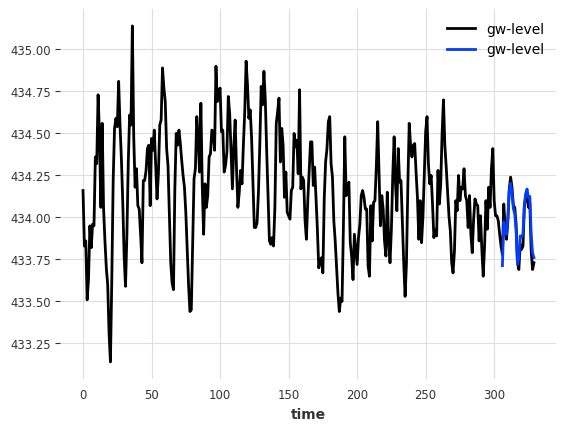

In [16]:
y_all.plot()
pred.plot()

In [13]:
from darts.metrics import mape

# Calculate MAPE
mape_value = mape(y_all[-24:], pred)

print(f"MAPE: {mape_value:.2f}%")

MAPE: 0.01%


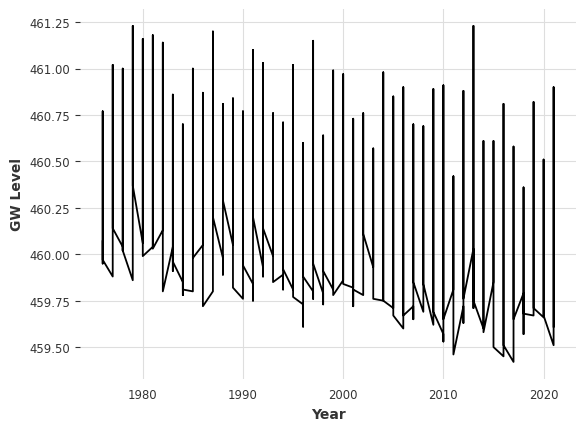

In [14]:
df = series_df.copy()
df = df.set_index("year")

# Plot using pandas plot function
df.plot(y="gw-level", xlabel="Year", ylabel="GW Level", legend=False)
plt.show()

In [16]:
y = TimeSeries.from_series(series_df["gw-level"])

In [17]:
y_train = y[:-24]

<TimeSeries (DataArray) (time: 527, component: 1, sample: 1)>
array([[[460.07]],

       [[459.96]],

       [[459.95]],

       [[460.24]],

       [[460.59]],

       [[460.77]],

       [[460.54]],

       [[460.66]],

       [[460.61]],

       [[460.16]],

...

       [[460.28]],

       [[460.27]],

       [[460.51]],

       [[460.82]],

       [[460.31]],

       [[460.14]],

       [[460.  ]],

       [[459.79]],

       [[459.85]],

       [[459.71]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 519 520 521 522 523 524 525 526
  * component  (component) object 'gw-level'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None